In [2]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import muon as mu
import scirpy as ir
np.random.seed(42)
import random
random.seed(42)

2025-08-26 20:47:07.471604: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 20:47:11.037632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756255632.270706 2561353 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756255632.634161 2561353 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756255635.578241 2561353 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## load mdata

In [3]:
mdata = mu.read("/ix1/ylee/Yifan_Zhang/Code_data/data_EAE/anndata/all_Common.h5mu")
prefixes_to_remove = ('CMO', 'ENSM', 'mt'
                      'Trav', 'Traj', 'Trac', 'Trbv', 'Trbj', 
                     'Trbc', 'Trdv', 'Trdj', 'Trdc', 'Trgv', 'Trgj', 'Trgc') 

TCR_gene_mask = mdata.var_names.str.startswith(prefixes_to_remove)
mdata = mdata[:, ~TCR_gene_mask]

mdata['gex'].var_names_make_unique()

sc.pp.normalize_total(mdata['gex'])
sc.pp.log1p(mdata['gex'])

In [4]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

# by nucleotide acid seq
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(mdata, min_cells=10)

In [5]:
meta_airr = ir.get.airr(mdata['airr'], ["cdr3_aa", "v_call", "j_call"] ,  ('VJ_1', 'VDJ_1'))
mdata.obs = mdata.obs.join(meta_airr)
mdata.update()


In [6]:
mdata

MuData object with n_obs × n_vars = 77660 × 33312
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'VJ_1_cdr3_aa', 'VJ_1_v_call', 'VJ_1_j_call', 'VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call'
  2 modalities
    gex:	77660 x 33312
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'mouse_BC'
      uns:	'log1p'
    airr:	77660 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id', 'clonotype_network'
      obsm:	'airr', 'chain_indices', 'X_clonotype_network'

In [7]:
Treg2D2_idx = (mdata['gex'].obs['mouse_id'].astype('str').isin(['5_3','5_4']))
mdata_2D2 = mdata[Treg2D2_idx.astype('bool')]

mdata_2D2

View of MuData object with n_obs × n_vars = 12457 × 33312
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'VJ_1_cdr3_aa', 'VJ_1_v_call', 'VJ_1_j_call', 'VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call'
  2 modalities
    gex:	12457 x 33312
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'mouse_BC'
      uns:	'log1p'
    airr:	12457 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id', 'clonotype_network'
      obsm:	'airr', 'chain_indices', 'X_clonotype_network'

In [8]:
mdata_2D2.obs['manual_cell_type'].value_counts()

manual_cell_type
multiplet    82
CD8+ T       41
CD4+ T       38
Treg         35
Myeloid      12
Name: count, dtype: int64

## QC

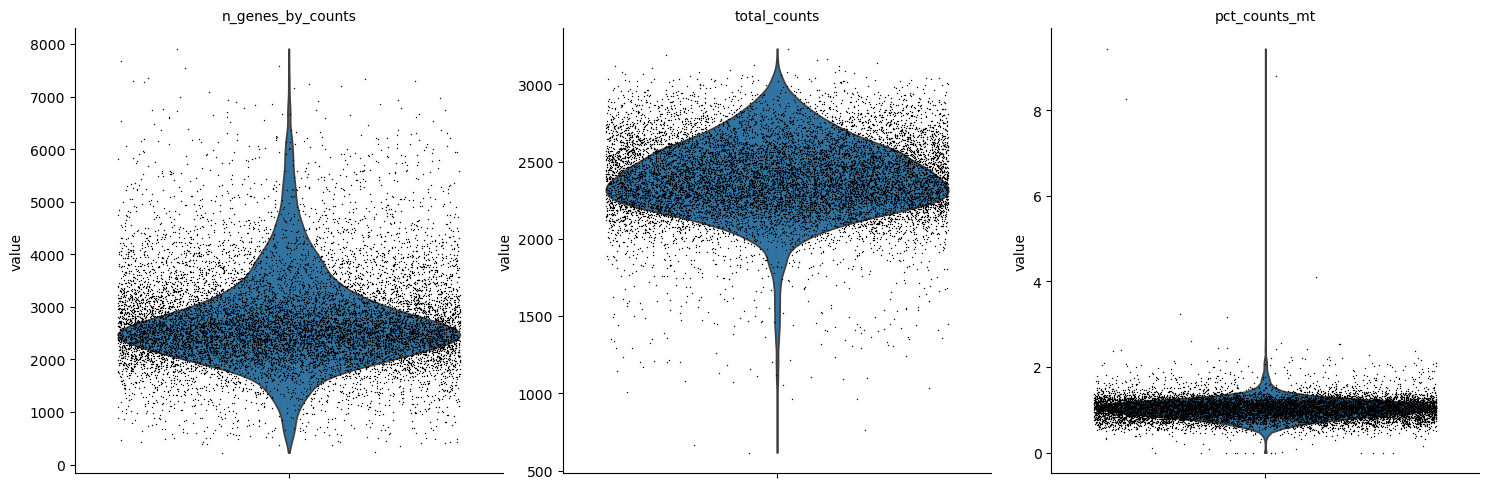

In [9]:
mdata = mdata_2D2

mdata['gex'].var["mt"] = mdata['gex'].var_names.str.startswith("mt-")
# ribosomal genes
mdata['gex'].var["ribo"] = mdata['gex'].var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
mdata['gex'].var["hb"] = mdata['gex'].var_names.str.contains("^Hb[^(p)]")

sc.pp.calculate_qc_metrics(
    mdata['gex'], qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pp.filter_cells(mdata['gex'], min_genes=200)
sc.pp.filter_cells(mdata['gex'], max_genes= 8000)

sc.pp.filter_cells(mdata['gex'], min_counts=100)
sc.pp.filter_cells(mdata['gex'], max_counts=40000)

sc.pp.filter_genes(mdata['gex'], min_cells=50)

sc.pl.violin(
    mdata['gex'],
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [10]:
sc.pp.highly_variable_genes(mdata['gex'], n_top_genes=2000, batch_key="mouse_id")
mdata.mod['gex'] = mdata['gex'][:, mdata['gex'].var['highly_variable']].copy()

In [11]:
# sync obs across mods
idx1 = mdata.mod["airr"].obs.index
idx2 = mdata.mod["gex"].obs.index
common_cells = idx1.intersection(idx2)

# Subset gex to only include these cells
gex_subset = mdata.mod["gex"][common_cells, :].copy()
tcr_subset = mdata.mod["airr"][common_cells, :].copy()
# Create a new MuData object to preserve alignment

mdata_common = mu.MuData({"gex": gex_subset, "airr": tcr_subset})

# Copy previous metadata from the old mdata object
mdata_common.obs = mdata.obs.loc[mdata_common.mod["gex"].obs.index]
mdata = mdata_common
mdata

MuData object with n_obs × n_vars = 12454 × 2000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'VJ_1_cdr3_aa', 'VJ_1_v_call', 'VJ_1_j_call', 'VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call'
  2 modalities
    gex:	12454 x 2000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'mouse_BC', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'log1p', 'hvg'
    airr:	12454 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id', 'clonotype_network'
      obsm:	'airr', 'chain_indices', 'X_clonotype_network'

## Annotation

In [12]:
sc.pp.pca(mdata["gex"], svd_solver="arpack", n_comps=20)
sc.pp.neighbors(mdata["gex"], n_neighbors = 50)
sc.tl.umap(mdata["gex"], min_dist=0.5, spread=5.0)

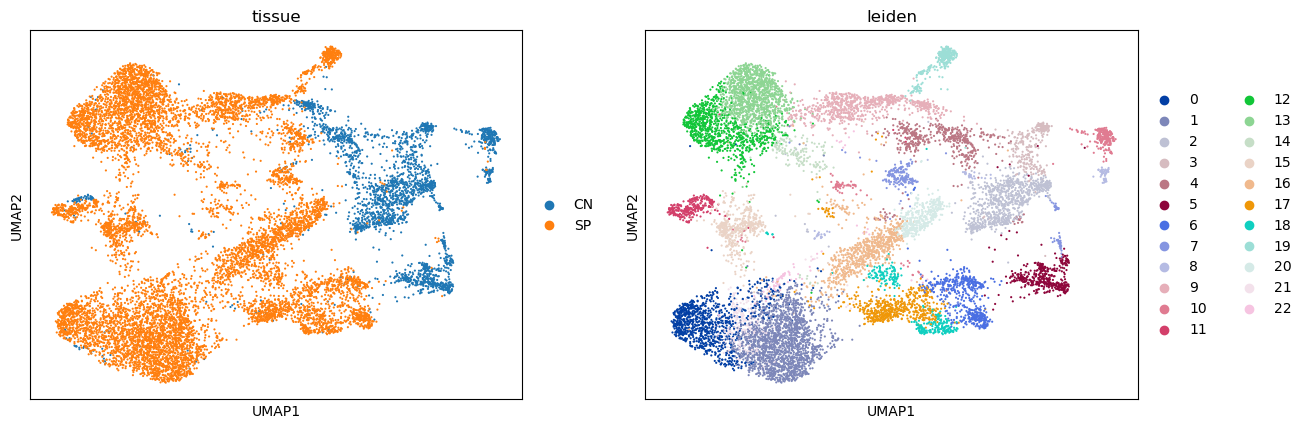

In [13]:
sc.tl.leiden(mdata["gex"], resolution = 1.5, n_iterations=-1, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["tissue", "leiden"])

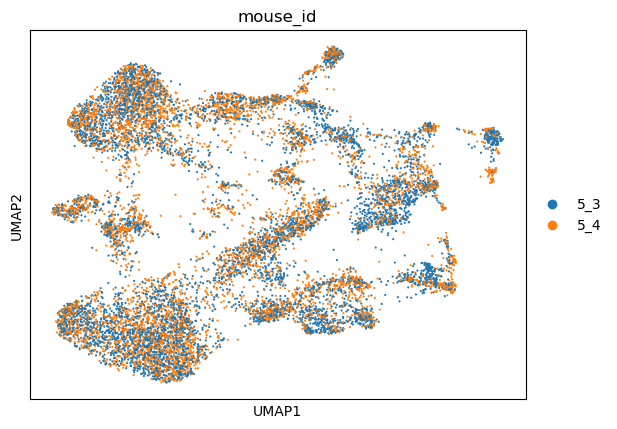

In [14]:
sc.pl.umap(mdata["gex"], color=["mouse_id"])

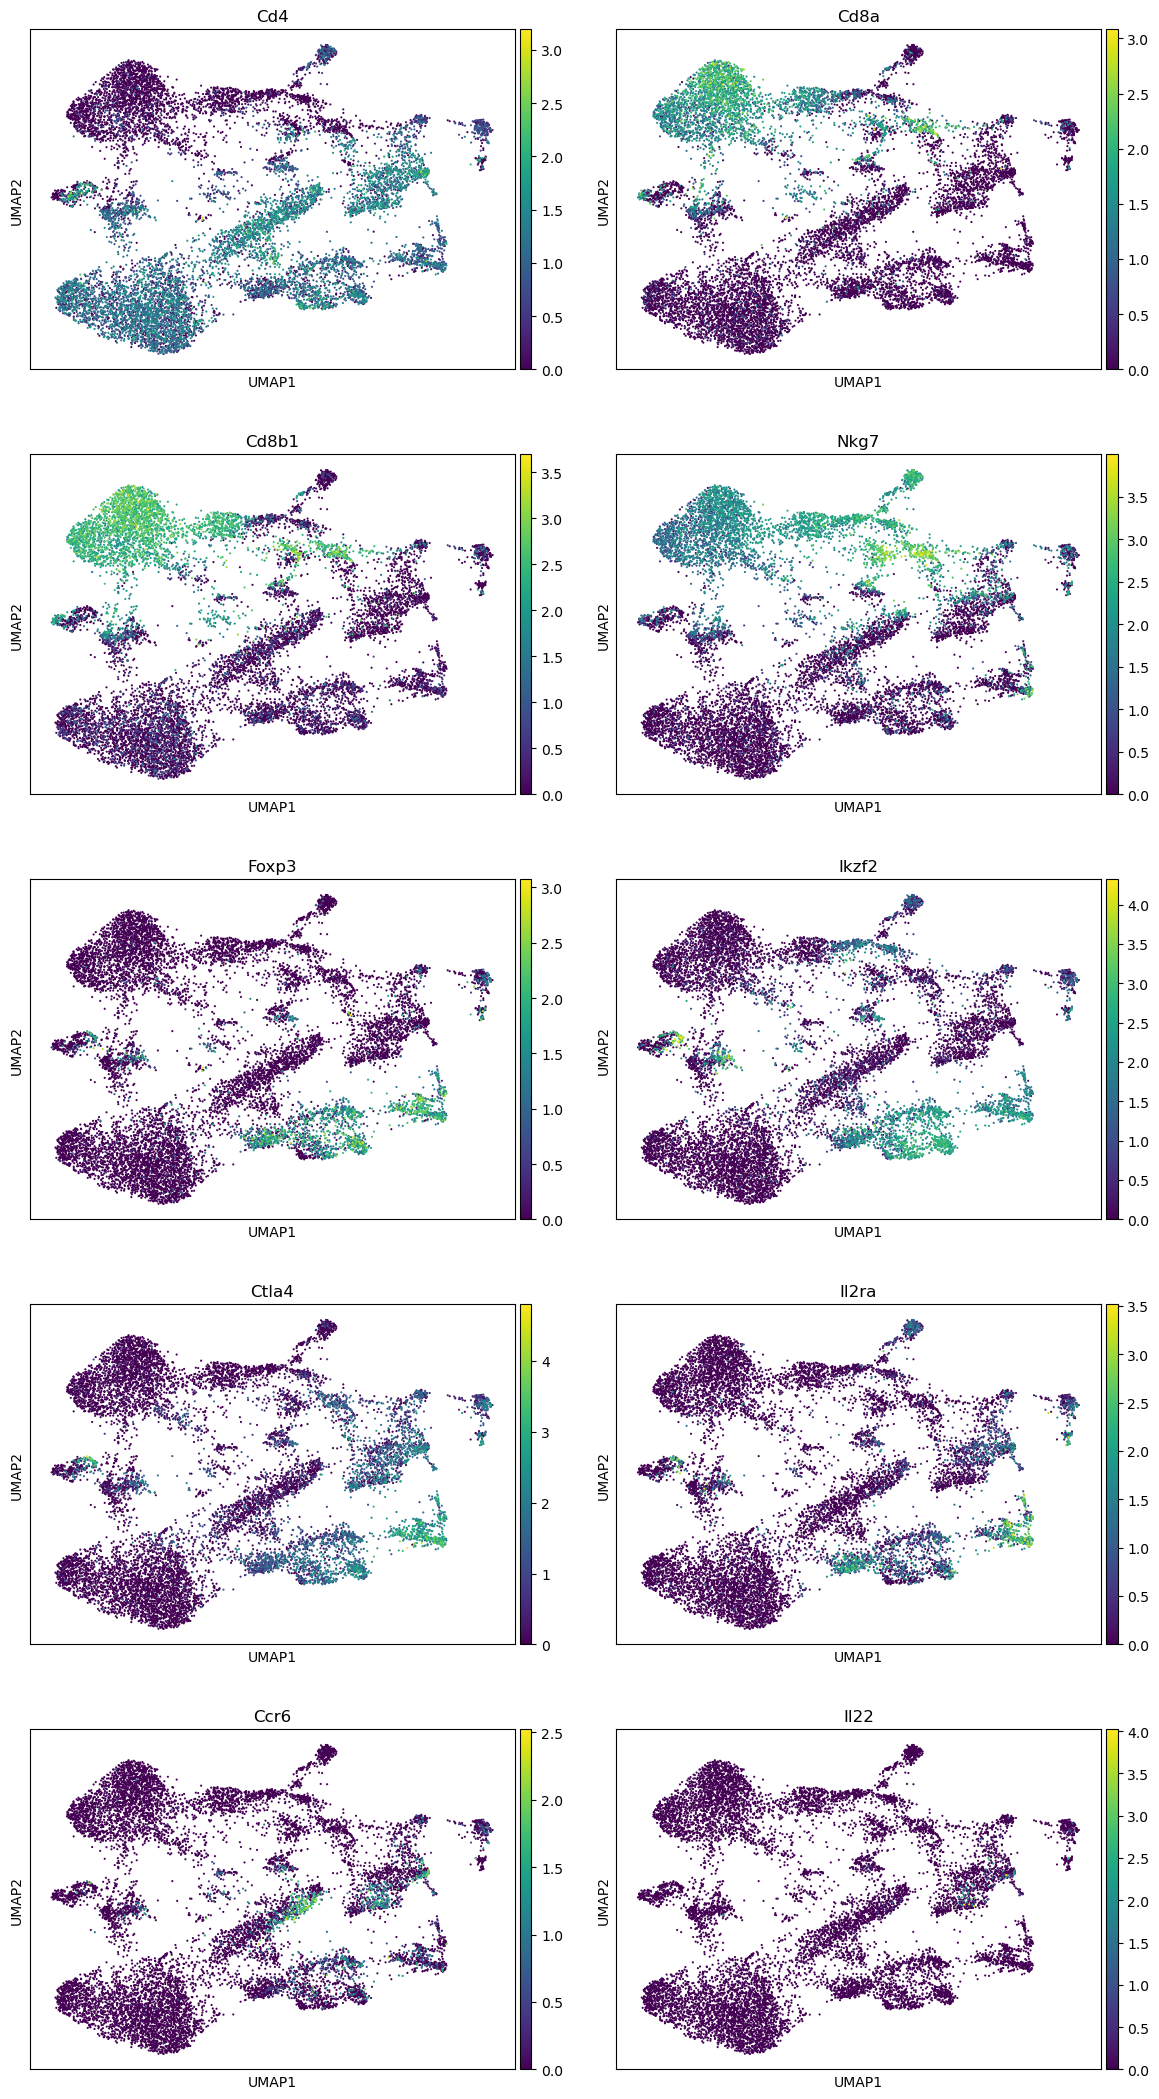

In [15]:
type_markers = ['Cd4', 'Cd8a','Cd8b1','Nkg7','Foxp3', 'Ikzf2', 'Ctla4', 'Il2ra','Ccr6', 'Il22']
state_markers = ['Isg15', 'Gbp2', 'Ifih1', 'Icos', 'Cd69', 'Cd28', 'Pdcd1', 'Lag3', 'Havcr2', 'Ccr7', 'Sell', 'Cd27']
markers_in = []

for i in type_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
        
mu.pl.embedding(mdata["gex"], basis="umap", color= markers_in,  wspace = 0.1, ncols=2, vmin=0)

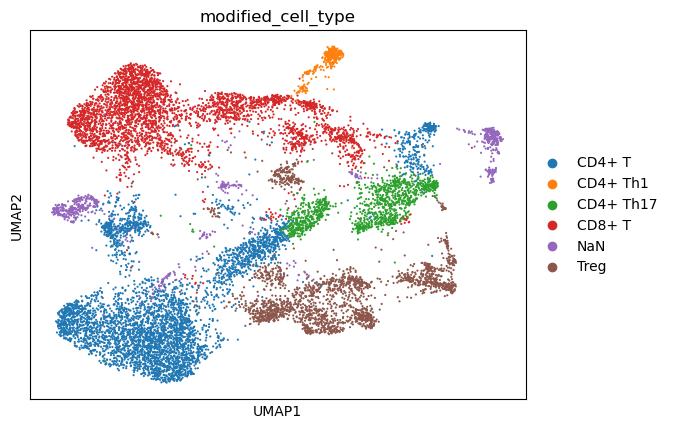

In [16]:
mdata["gex"].obs['modified_cell_type'] = 'NaN'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['12','13','9','4','14',])] = 'CD8+ T'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['5','6','7','17','18'])] = 'Treg'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['20','2'])] = 'CD4+ Th17'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['19'])] = 'CD4+ Th1'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['1','0','16','3','15','21'])] = 'CD4+ T'

sc.pl.umap(mdata["gex"], color=['modified_cell_type'])

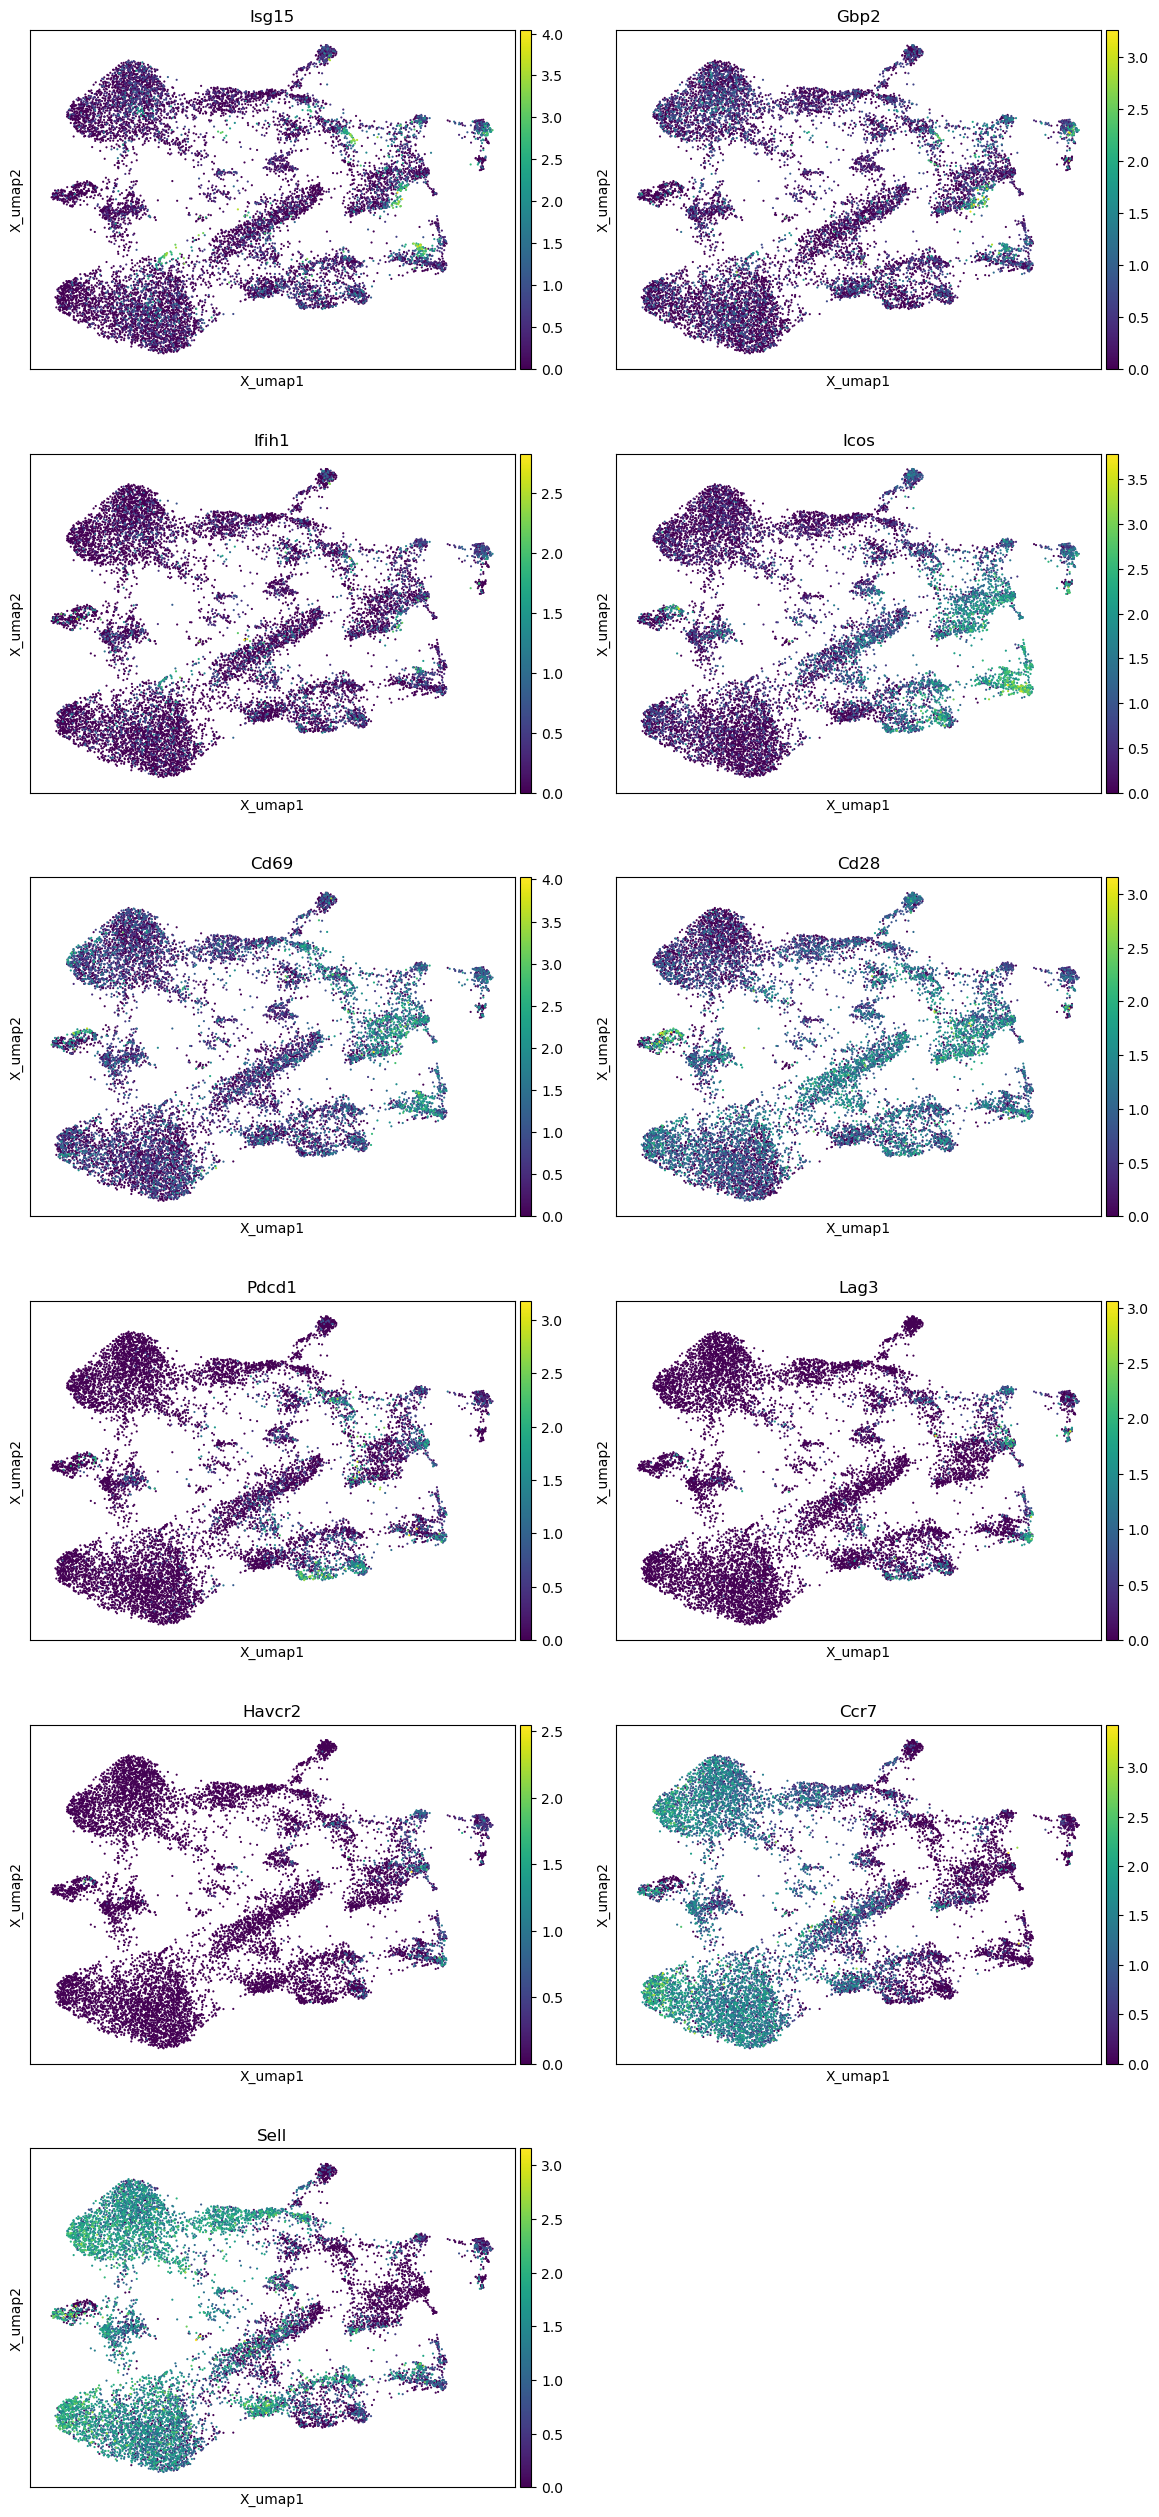

In [17]:
markers_in = []
for i in state_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
mu.pl.embedding(mdata, basis="gex:umap", color= markers_in, wspace = 0.1, ncols=2, vmin=0)

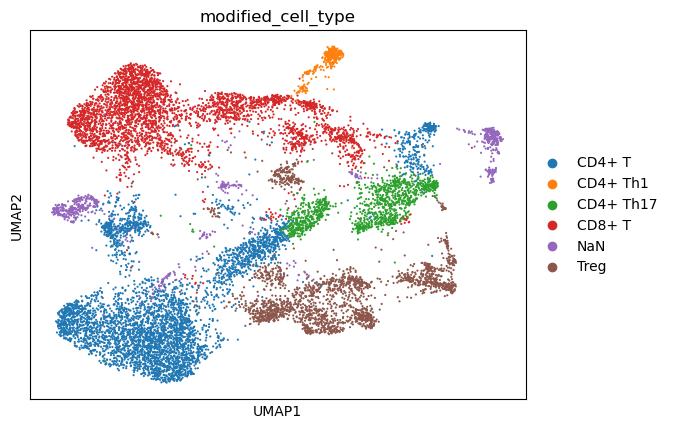

In [18]:
import scanpy as sc

IFN_stim = ['Isg15', 'Gbp2', 'Ifih1']
Activation = ['Icos', 'Cd69', 'Cd28']
Exhaust = ['Pdcd1', 'Lag3', 'Havcr2']
Mem = ['Ccr7', 'Sell', 'Cd27']

sc.tl.score_genes(mdata['gex'], gene_list=IFN_stim, score_name='IFN_stim')
sc.tl.score_genes(mdata['gex'], gene_list=Activation, score_name='Activation')
sc.tl.score_genes(mdata['gex'], gene_list=Exhaust, score_name='Exhaust')
sc.tl.score_genes(mdata['gex'], gene_list=Mem, score_name='Mem')

sc.pl.umap(mdata["gex"], color=['modified_cell_type'])

In [19]:
mdata['gex'].obs['state'] = 'Effector'
mdata['gex'].obs.loc[mdata['gex'].obs['Exhaust'] > 0.5, 'state'] = 'Exhausted'
mdata['gex'].obs.loc[mdata['gex'].obs['Mem'] > 0.5, 'state'] = 'Mem'
mdata['gex'].obs.loc[mdata['gex'].obs['IFN_stim'] > 0.5, 'state'] = 'activated'
mdata['gex'].obs.loc[mdata['gex'].obs['Activation'] > 0.5, 'state'] = 'activated'


## Scirpy EDA

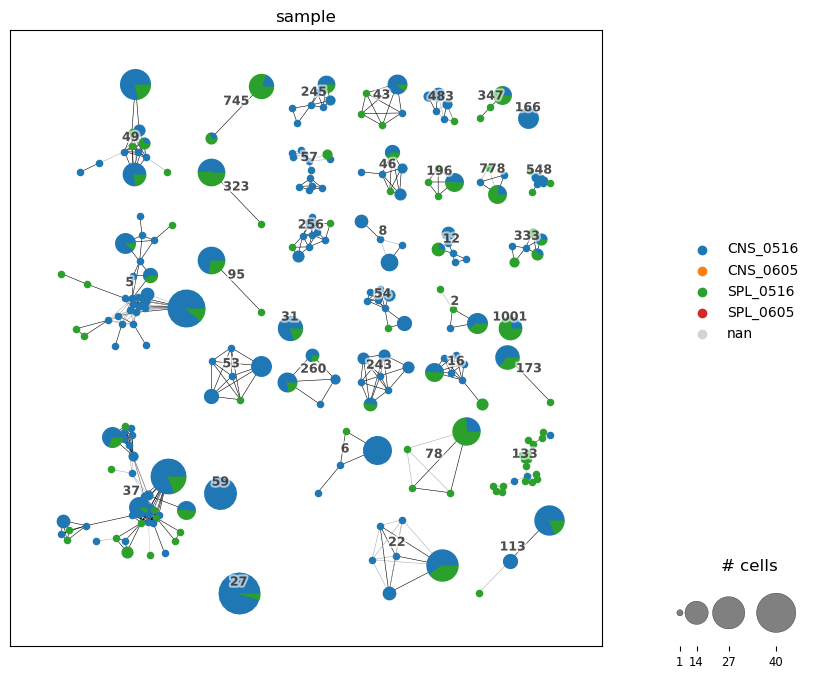

In [20]:
ir.pp.ir_dist(
    mdata,
    metric="tcrdist",
    sequence="aa",
    cutoff=15,
)

ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="all", dual_ir="any")
ir.tl.clonotype_network(mdata, min_cells=10, sequence="aa", metric="tcrdist")
_ = ir.pl.clonotype_network(mdata, color="sample", label_fontsize=9, panel_size=(8,8), base_size=20)


In [21]:
# Perform clonal expansion analysis
ir.tl.clonal_expansion(mdata)

mdata.obs["celltype_sample"] = (
    mdata['gex'].obs["modified_cell_type"].astype(str) + "_" + mdata.obs["sample"].astype(str)
)

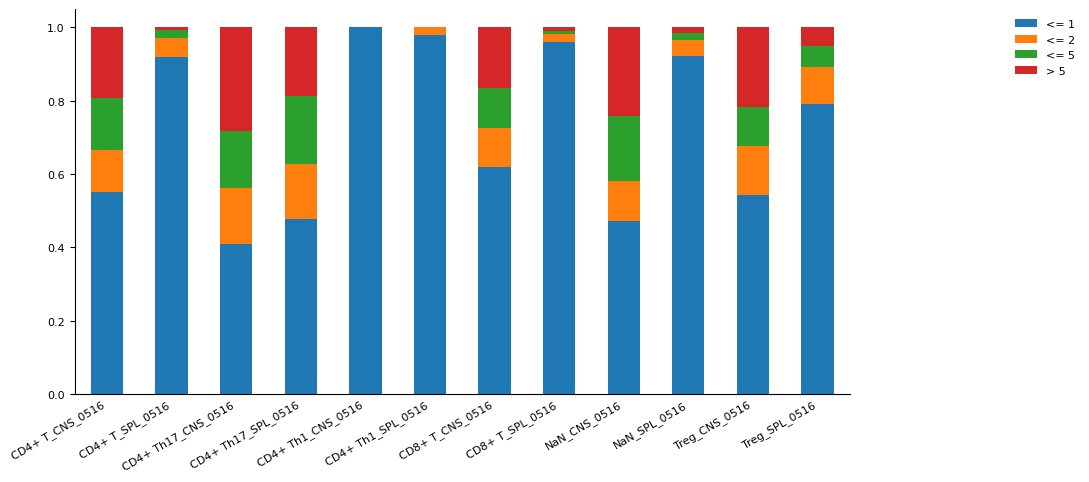

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = ir.pl.clonal_expansion(
    mdata, 
    target_col="clone_id",
    groupby="celltype_sample",  # Use the new combined column
    breakpoints=(1, 2, 5), 
    ax = ax
    #normalize=False
)

## clonotype dist

In [23]:
# select cells appear in both CNS and SPL

# thresh on clono size
clone_thresh = 3
mdata.obs['cloned'] = mdata['airr'].obs['clone_id_size'] >= clone_thresh

# Check if appear in two tissues
mdata_cloned = mdata[mdata.obs['cloned']]
clone_tissue_df = mdata_cloned['airr'].obs[['clone_id']].join(mdata_cloned['gex'].obs['tissue'])
clone_tissue_counts = clone_tissue_df.groupby('clone_id')['tissue'].nunique()
multi_tissue_clones = clone_tissue_counts[clone_tissue_counts > 1].index
mdata.obs['in_two_tissue'] = mdata['airr'].obs['clone_id'].isin(multi_tissue_clones)


mdata.obs['in_two_tissue'].value_counts()

in_two_tissue
False    11505
True       949
Name: count, dtype: int64

## 2D2 TCR dist

In [25]:
from tcrdist.repertoire import TCRrep
# formating by tcrdist requirements
ref_df = pd.read_csv('data/TCRdist/std_MOG_assays.csv')
ref_df.rename(columns={'Chain 2 CDR3': 'cdr3_b_aa', 'Chain 2 V Gene':'v_b_gene', 
                   'Chain 2 J Gene':'j_b_gene', }, inplace=True)

ref_df['v_b_gene'] = ref_df['v_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')
ref_df['j_b_gene'] = ref_df['j_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')


In [26]:
def mdata_TCR_formating(mdata_subset):
    query_df = mdata_subset.obs[['VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call']]
    query_df['cell_id'] = query_df.index
    query_df.dropna(subset = ["VDJ_1_cdr3_aa"])

    query_df.rename(columns={'VDJ_1_cdr3_aa': 'cdr3_b_aa', 'VDJ_1_v_call':'v_b_gene', 
                       'VDJ_1_j_call':'j_b_gene', }, inplace=True)

    # 'VDJ_1_consensus_count':'count'
    # query_df['cdr3_b_aa'] = 'C' + query_df['cdr3_b_aa'].astype(str) + 'F'

    query_df['v_b_gene'] = query_df['v_b_gene'].str.split('+').str[0]
    query_df['j_b_gene'] = query_df['j_b_gene'].str.split('+').str[0]

    query_df['v_b_gene'] = query_df['v_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')
    query_df['j_b_gene'] = query_df['j_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')

    # query_df_clones = query_df_clones.drop(columns=["cell_id"])
    query_df_unique = query_df.drop_duplicates(['cdr3_b_aa'])
    return query_df_unique


In [27]:
def TCRdist_to_ref(ref_df, query_df_unique):
    tr_ref = TCRrep(cell_df = ref_df, 
                organism = 'mouse', 
                chains = ['beta'],
                compute_distances = False,)

    tr_q = TCRrep(cell_df = query_df_unique, 
                organism = 'mouse', 
                chains = ['beta'],
                compute_distances = False,)

    tr_ref.compute_rect_distances(tr_ref.clone_df,  tr_q.clone_df)
    print(tr_ref.rw_beta.shape)
    print(tr_ref.rw_beta)
    return tr_ref, tr_q


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dist_thres = 85
tr_list = []

# 'in_two_tissue' ,  'cloned'
mdata_sub = mdata[mdata.obs['cloned']]
# mdata_sub = mdata

query_df = mdata_TCR_formating(mdata_sub)

tr_out, tr_query = TCRdist_to_ref(ref_df, query_df)
tr_list.append(tr_out)
flat_arr = tr_out.rw_beta.min(axis=0).flatten()
TCR_all = tr_query.clone_df
TCR_all['TCRdist_MOG'] = flat_arr

plt.hist(flat_arr, bins=50, density=True, alpha=0.4)

selected_clone_id = flat_arr < dist_thres
TCR_selected = TCR_all[selected_clone_id]
    

# # Example 2D array
# arr = tr.rw_beta.min(axis=0)

# # Flatten to 1D
# flat_arr = arr.flatten()

# Plot KDE (Kernel Density Estimate)
plt.xlim([0, 175])
plt.legend(['two tissue', 'one tissue'])
plt.title("Histogram of 2D Array Elements")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

In [ ]:
sub_2d2 = TCR_all[TCR_all['cdr3_b_aa']=='ASSLDCGANP']
sub_2d2

In [ ]:
TCR_all.to_csv('TCR_cloned_dist_2d2.csv')

## DAE dist

In [ ]:
mdata_temp = mdata
TCR_all['cdr3_b_aa_trimed'] = TCR_all['cdr3_b_aa'].str[1:-1].astype(str)

TCR_df = TCR_all[['cdr3_b_aa_trimed', 'TCRdist_MOG']]

mdata_temp = mdata_temp[mdata.obs['VDJ_1_cdr3_aa'].isin(TCR_all['cdr3_b_aa_trimed'])]
mdata_temp.obs['sc_BC'] = mdata_temp['gex'].obs.index

mdata_temp.obs = mdata_temp.obs.merge(TCR_df, how='left', left_on='VDJ_1_cdr3_aa', right_on='cdr3_b_aa_trimed')
mdata_temp.obs.set_index(mdata_temp.obs['sc_BC'], inplace=True)

In [ ]:
type_markers = ['Cd4', 'Cd8a','Cd8b1','Nkg7','Foxp3', 'Ikzf2', 'Ctla4', 'Il2ra','Ccr6', 'Il22']
state_markers = ['Isg15', 'Gbp2', 'Ifih1', 'Icos', 'Cd69', 'Cd28', 'Pdcd1', 'Lag3', 'Havcr2', 'Ccr7', 'Sell', 'Cd27']
markers_in = []

for i in state_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 


In [ ]:
clone_thresh = 5
mdata_temp.obs['cloned'] = mdata_temp['airr'].obs['clone_id_size'] >= clone_thresh

# Check if appear in two tissues
mdata_cloned = mdata_temp[mdata_temp.obs['cloned']]
clone_tissue_df = mdata_cloned['airr'].obs[['clone_id']].join(mdata_cloned['gex'].obs['tissue'])
clone_tissue_counts = clone_tissue_df.groupby('clone_id')['tissue'].nunique()
multi_tissue_clones = clone_tissue_counts[clone_tissue_counts > 1].index

mdata_temp.obs['in_two_tissue'] = mdata_temp['airr'].obs['clone_id'].isin(multi_tissue_clones)


In [ ]:
mdata_temp.obs['is_sim'] = 'mid'
mdata_temp.obs['is_sim'][mdata_temp.obs['TCRdist_MOG'] < 60] = 'True'
mdata_temp.obs['is_sim'][mdata_temp.obs['TCRdist_MOG'] > 140] = 'False'
mdata_temp = mdata_temp[mdata_temp.obs['is_sim'].isin(['True', 'False'])]

In [ ]:
import scanpy as sc
sc.pp.pca(mdata_temp["gex"], svd_solver="arpack", n_comps=10)
sc.pp.neighbors(mdata_temp["gex"], use_rep='X_pca', n_neighbors = 10)
sc.tl.umap(mdata_temp["gex"], min_dist=0.5, spread=1.0)

In [ ]:
## subseting
mdata_temp.update()
# mdata_sub = mdata_temp[ (mdata_temp.obs['cloned']) & (~mdata_temp.obs['in_two_tissue'])]

mdata_sub = mdata_temp[mdata_temp.obs['in_two_tissue']]

# mdata_sub = mdata_temp[mdata_temp.obs['cloned']]    

# mdata_sub = mdata_temp

group_name = 'is_sim'
mdata_sub['gex'].obs[group_name] = mdata_sub.obs[group_name].astype('category')
mdata_sub['gex'].obs[group_name].value_counts()

In [ ]:
sc.pl.umap(mdata_sub["gex"], color=["tissue", 'is_sim'])

In [ ]:
groups = ['True', 'False']
sc.tl.rank_genes_groups(mdata_sub['gex'], groupby = group_name, groups=groups, method="wilcoxon")
df = sc.get.rank_genes_groups_df(mdata_sub['gex'], group = 'True')


In [ ]:
sc.pl.rank_genes_groups_dotplot(mdata_sub['gex'], groupby=group_name, groups=groups,
                                    cmap='Blues')
# var_names=markers_in,

In [ ]:
df_true = df.head(10)
df_true

In [ ]:
df_false = sc.get.rank_genes_groups_df(mdata_sub['gex'], group = 'False').head(10)
df_false

In [ ]:
pval_type = df[df["names"].isin(type_markers)]
pval_type["gene"] = pd.Categorical(pval_type["names"], categories=type_markers, ordered=True)
pval_type = pval_type.sort_values("gene")
pval_type

In [ ]:
var_group_positions = [(0,0), (1,3), (4, 7), (8, 9)]   # inclusive start, inclusive end
var_group_labels = ["CD4 T", "CD8 T", "Treg", "Th17"]

dp = sc.pl.dotplot(
    mdata_sub['gex'], var_names=type_markers, groupby=group_name, cmap="Blues",
    var_group_positions=var_group_positions,
    var_group_labels=var_group_labels,
    show=False, return_fig=True
)
dp.make_figure()

def p2stars(p):
    if p < 1e-4: return "****"
    elif p < 1e-3: return "***"
    elif p < 1e-2: return "**"
    elif p < 5e-2: return "*"
    else: return ""

    # dict (or Series) of p-values per gene (fill with yours)
pvals = dict(zip(pval_type['names'], pval_type['pvals'])) # example; replace with real p-values
ax = dp.get_axes()["mainplot_ax"]

# get current tick labels
yticklabels = [t.get_text() for t in ax.get_xticklabels()]

# prepend stars to gene names
new_labels = [f"{p2stars(pvals.get(g,1))}  {g}" for g in yticklabels]
ax.set_xticklabels(new_labels)
plt.show()

In [ ]:
pval_state = df[df["names"].isin(markers_in)]
pval_state["gene"] = pd.Categorical(pval_state["names"], categories=markers_in, ordered=True)
pval_state = pval_state.sort_values("gene")
pval_state

In [ ]:
var_group_positions = [(0,2), (3,5), (6,8), (9, 9)]   # inclusive start, inclusive end
var_group_labels = ["IFN stim", "act", "Exhaust", "Central mem"]

dp = sc.pl.dotplot(
    mdata_sub['gex'], var_names=markers_in, groupby=group_name, cmap="Blues",
    var_group_positions=var_group_positions,
    var_group_labels=var_group_labels,
    show=False, return_fig=True
)
dp.make_figure()

# dict (or Series) of p-values per gene (fill with yours)
pvals =  dict(zip(pval_state['names'], pval_state['pvals'])) # example; replace with real p-values

ax = dp.get_axes()["mainplot_ax"]

# get current tick labels
yticklabels = [t.get_text() for t in ax.get_xticklabels()]

# prepend stars to gene names
new_labels = [f"{p2stars(pvals.get(g,1))}  {g}" for g in yticklabels]
ax.set_xticklabels(new_labels)
plt.show()

In [ ]:
## subset by TCR dist
mdata_temp = mdata_temp[mdata_temp.obs['VDJ_1_cdr3_aa'].isin(TCR_selected['cdr3_b_aa_trimed'])]
mdata_temp                    

In [ ]:
# mdata_subset = mdata
import scanpy as sc
sc.pp.pca(mdata_temp["gex"], svd_solver="arpack", n_comps=10)
sc.pp.neighbors(mdata_temp["gex"], use_rep='X_pca', n_neighbors = 10)
sc.tl.umap(mdata_temp["gex"], min_dist=0.5, spread=1.0)
sc.tl.leiden(mdata_temp["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata_temp["gex"], color=["tissue"])

In [ ]:
mdata_temp.obs['manual_cell_type'] = mdata_temp.obs['manual_cell_type'].cat.remove_unused_categories()
mu.pl.embedding(mdata_temp, basis="gex:umap", color= ['manual_cell_type', 'gex:mouse_id'], wspace = 0.2, ncols=2, vmin=0)

In [ ]:
chemokine_all = [g for g in mdata_temp["gex"].var_names if g.startswith(("Cc", "Cxc", "Cx3c"))]

# markers_in = []
# for i in chemokine:
#     if i in mdata_subset["gex"].var_names:
#         markers_in.append(i) 

In [ ]:
sc.tl.rank_genes_groups(mdata_temp["gex"], groupby ="tissue",  method="wilcoxon")
# mask_var = chemokine_all,

# sc.pl.rank_genes_groups_heatmap(mdata_subset["gex"], groupby = "tissue", gene_symbols= chemokine_all,
#                                  cmap='bwr',)

In [ ]:
# Get results as DataFrame
df = sc.get.rank_genes_groups_df(mdata_temp["gex"], group="CN")

# Filter to certain genes
df_filtered = df[df["names"].isin(chemokine_all)]

print(df_filtered.head(5))

In [ ]:
chemokine_topDE = df_filtered['names'].head(10)

mu.pl.embedding(mdata_temp, basis="gex:umap", color= chemokine_topDE[:4], ncols=2, vmin=0)

In [ ]:
expr_chemokine = mdata['gex'][:, chemokine_topDE.values].to_df()
expr_chemokine

In [ ]:
type_markers = ['Cd4', 'Cd8a','Cd8b1','Nkg7','Foxp3', 'Ikzf2', 'Ctla4', 'Il2ra','Ccr6', 'Il22']
state_markers = ['Isg15', 'Gbp2', 'Ifih1', 'Icos', 'Cd69', 'Cd28', 'Pdcd1', 'Lag3', 'Havcr2', 'Ccr7', 'Sell', 'Cd27']
markers_in = []

for i in state_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
markers_in
expr_markers = mdata['gex'][:, markers_in].to_df()
expr_markers.to_csv('marker_genes_for_training.csv')

In [ ]:
# expr_chemokine.to_csv('top10_chemok.csv')

In [ ]:
sc.pl.rank_genes_groups_dotplot(mdata_temp["gex"],  groupby="tissue", 
                                   var_names=chemokine_topDE[:10], cmap='Blues')


In [ ]:
vars_target_df = pd.read_csv('top10_chemok.csv')
sc.pl.rank_genes_groups_dotplot(mdata_temp["gex"],  groupby="tissue", 
                                   var_names=vars_target_df.columns[1:], cmap='Purples')    # 'Greens', 'Reds', 'Purples'


In [ ]:
TCR_matched = matrix[matrix['cdr3_b_aa'].isin(TCR_selected['cdr3_b_aa'])]
TCR_matched

In [ ]:
TCR_matched['manual_cell_type'].value_counts()

In [ ]:
TCR_matched['sample'].value_counts()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

EM_dim = 97
# max = 97
EM_matrix = TCR_matched.iloc[:,1:EM_dim]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(EM_matrix)

k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, copy_x=False)
clusters = kmeans.fit_predict(X_scaled)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, svd_solver='randomized', random_state=42)
X_pca_GIANA = pca.fit_transform(X_scaled)

import umap
umap = umap.UMAP(n_components=2, random_state=42, n_neighbors = 20, min_dist = 0.5)
# umap = umap.UMAP(n_components=2, random_state=42)

X_r = umap.fit_transform(X_pca_GIANA)

In [ ]:
# plot
import seaborn as sns

fig, axes = plt.subplots(2,2, figsize=(10,10))

# Create DataFrame
df = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': TCR_matched['sample']
})
sns.scatterplot(data=df, x='x', y='y', hue='label', s=10, ax = axes[0][0])

df2 = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': TCR_matched['manual_cell_type']
})
sns.scatterplot(data=df2, x='x', y='y', hue='label', s=10, ax = axes[0][1])

df3 = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': clusters
})
sns.scatterplot(data=df3, x='x', y='y', hue='label', s=10, palette="deep", ax = axes[1][0])


In [ ]:
%cd /ihome/ylee/yiz133/Code/deepTCR/unSupervised_cluster

In [ ]:
# Create a sample 2D matrix
matrix = pd.read_csv('DTCRU_extracted_features_96_0605.csv', sep = ',')
matrix.drop(columns={'Label'}, inplace=True)

matrix['CDR3_Beta'] = matrix['CDR3_Beta'].str[1:-1]

matrix = pd.merge(matrix, TCR_selected, left_on='CDR3_Beta', right_on='cdr3_b_aa', how='inner')

In [ ]:
m_right = mdata.obs[['VDJ_1_cdr3_aa','manual_cell_type','sample']]
m_right['BC'] = mdata.obs.index
deepTCR_matrix = pd.merge(matrix, m_right, left_on='CDR3_Beta', right_on = 'VDJ_1_cdr3_aa', how='inner')
deepTCR_matrix

In [ ]:
deepTCR_matrix['manual_cell_type'].value_counts()

In [ ]:
deepTCR_matrix['sample'].value_counts()

In [ ]:
EM_dim = 97
EM_matrix_deepTCR = deepTCR_matrix.iloc[:,3:EM_dim]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(EM_matrix_deepTCR)

k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, copy_x=False)
clusters = kmeans.fit_predict(X_scaled)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, svd_solver='randomized', random_state=42)

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=30, kernel='rbf', gamma=0.1)

# generate features
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, include_bias=False)
# EM_matrix_deepTCR = poly.fit_transform(EM_matrix_deepTCR)

import umap
umap = umap.UMAP(n_components=2, random_state=42, n_neighbors = 20, min_dist = 0.5)
# umap = umap.UMAP(n_components=2, random_state=42)

# transform
X_pca_deepTCR = kpca.fit_transform(EM_matrix_deepTCR)
X_r = umap.fit_transform(X_pca_deepTCR)


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

# Create DataFrame
df = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': deepTCR_matrix['sample']
})
sns.scatterplot(data=df, x='x', y='y', hue='label', s=30, ax = axes[0])

df2 = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': deepTCR_matrix['manual_cell_type']
})
sns.scatterplot(data=df2, x='x', y='y', hue='label', s=20, ax = axes[1])


In [ ]:
# GIANA emb
# M = matrix.copy()

# deepTCR emb
M = deepTCR_matrix.copy()
M_embs = M.iloc[:,3:99]
M_obs = M.drop(M.columns[3:99], axis=1)

kpca = KernelPCA(n_components=30, kernel='rbf', gamma=0.1)
M_embs = kpca.fit_transform(M_embs)

M_obs['tissue'] = M_obs['sample'].str[:3]

In [ ]:
import anndata as ad

adata_embs = ad.AnnData(M_embs)
adata_embs.obs = M_obs

adata_embs

In [ ]:
sc.tl.rank_genes_groups(adata_embs, groupby = "tissue", reference = 'SPL')
    
sc.pl.rank_genes_groups_violin(adata_embs,  n_genes=5)

In [ ]:
aaa

In [ ]:
from sklearn.decomposition import PCA
import umap
import igraph as ig
import leidenalg

pca = PCA(n_components=25, random_state=42)
X_pca = pca.fit_transform(X_scaled)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_pca)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Compute the k-nearest neighbors
knn = NearestNeighbors(n_neighbors=15)
knn.fit(X_pca)
adj_matrix = knn.kneighbors_graph(X_pca, mode='connectivity')

In [ ]:
# Convert the adjacency matrix to a CSR format if it's not already
adj_csr = adj_matrix.tocsr()

# Create an igraph graph from the adjacency matrix
sources, targets = adj_csr.nonzero()
edges = list(zip(sources, targets))
g = ig.Graph(edges=edges, directed=False)


In [ ]:
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)
labels = np.array(partition.membership)


In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=10)
plt.title('UMAP Projection with Leiden Clustering')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


In [ ]:
import anndata as ad
import scanpy as sc

EM_matrix = EM_matrix.dropna()
adata = ad.AnnData(EM_matrix)
# adata.obs['cluster'] = clusters
adata.obs['tissue'] = tissue
adata.obs['AA_seq'] = matrix.iloc[:,1]
adata


In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)


In [ ]:
np.isnan(adata.X).any()

In [ ]:
nan_indices = np.argwhere(np.isnan(adata.X))
nan_indices

In [ ]:
sc.pp.pca(adata, svd_solver="arpack", n_comps=20)
sc.pp.neighbors(mdata["gex"], n_neighbors = 20)
sc.tl.umap(mdata["gex"], min_dist=0.5, spread=1.0)
sc.tl.leiden(mdata["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["leiden"])


In [ ]:
# adata.write('TCRemb_2cluster.h5ad')